In [1]:
%matplotlib inline

In [2]:
import os

In [3]:
%run notebook_setup

# Load data in from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [4]:
import os
HOME = os.environ['HOME']
os.chdir(f'{HOME}/Research/Planets/WASP43/github_analysis/notebooks')

In [48]:
import exoplanet as xo
import joblib
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import pymc3 as pm

from exomast_api import exoMAST_API
from statsmodels.robust.scale import mad
from time import time
from tqdm import tqdm_notebook as tqdm

from arctor import create_raw_lc_stddev, Arctor, run_multiple_pymc3 # instantiate_arctor, 

ImportError: cannot import name 'run_multiple_pymc3' from 'arctor' (/home/nelly/Research/Planets/WASP43/github_analysis/arctor/__init__.py)

In [6]:
def debug_message(message, end='\n'):
    print(f'[DEBUG] {message}', end=end)


def warning_message(message, end='\n'):
    print(f'[WARNING] {message}', end=end)


def info_message(message, end='\n'):
    print(f'[INFO] {message}', end=end)

In [7]:
plot_verbose = False
save_now = False
planet_name = 'WASP43'
file_type = 'flt.fits'

HOME = os.environ['HOME']
base_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43')
data_dir = os.path.join(base_dir, 'data', 'UVIS', 'MAST_2019-07-03T0738')
data_dir = os.path.join(data_dir, 'HST', 'FLTs')
working_dir = os.path.join(base_dir, 'github_analysis', 'savefiles')

In [8]:
planet = Arctor(planet_name, data_dir, working_dir, file_type)
joblib_filename = 'WASP43_savedict_206ppm_100x100_finescale.joblib.save'
joblib_filename = f'{working_dir}/{joblib_filename}'
planet.load_dict(joblib_filename)

[INFO] Initializing Instance of the `Arctor` Object


In [9]:
planet.photometry_df.columns

Index(['aperture_sum_11x41', 'aperture_sum_12x41', 'aperture_sum_13x41',
       'aperture_sum_14x41', 'aperture_sum_15x41', 'aperture_sum_16x41',
       'aperture_sum_17x41', 'aperture_sum_18x41', 'aperture_sum_19x41',
       'aperture_sum_20x41',
       ...
       'aperture_sum_23x60', 'aperture_sum_24x60', 'aperture_sum_25x60',
       'aperture_sum_26x60', 'aperture_sum_27x60', 'aperture_sum_28x60',
       'aperture_sum_29x60', 'aperture_sum_30x60', 'xcenter', 'ycenter'],
      dtype='object', length=402)

In [10]:
if not hasattr(planet, 'gaussian_centers'):
    # planet.load_dict(joblib_filename)
    planet.clean_cosmic_rays()
    planet.calibration_trace_location()
    planet.identify_trace_direction()
    planet.simple_phots()
    planet.center_all_traces()
    planet.fit_trace_slopes()
    planet.compute_sky_background(subpixels=32)
    planet.compute_columnwise_sky_background()

# Run Multi-Phot

In [11]:
if not hasattr(planet, 'photometry_df'):
    # Set up the list of aperture widths and heights to search
    min_aper_width = 1
    max_aper_width = 100
    min_aper_height = 1
    max_aper_height = 100

    aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
    aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)
    
    planet.do_multi_phot(aper_widths, aper_heights)

# Determine the 'best' photometry SNR

In [12]:
med_photometry_df = np.median(planet.photometry_df, axis=0)
planet.normed_photometry_df = planet.photometry_df / med_photometry_df
planet.normed_uncertainty_df = np.sqrt(planet.photometry_df) / med_photometry_df

In [13]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [14]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [15]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 209ppm with 20x50 aperture size; with median uncertainties of 126 ppm


# Configure system for PyMC3

In [16]:
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev

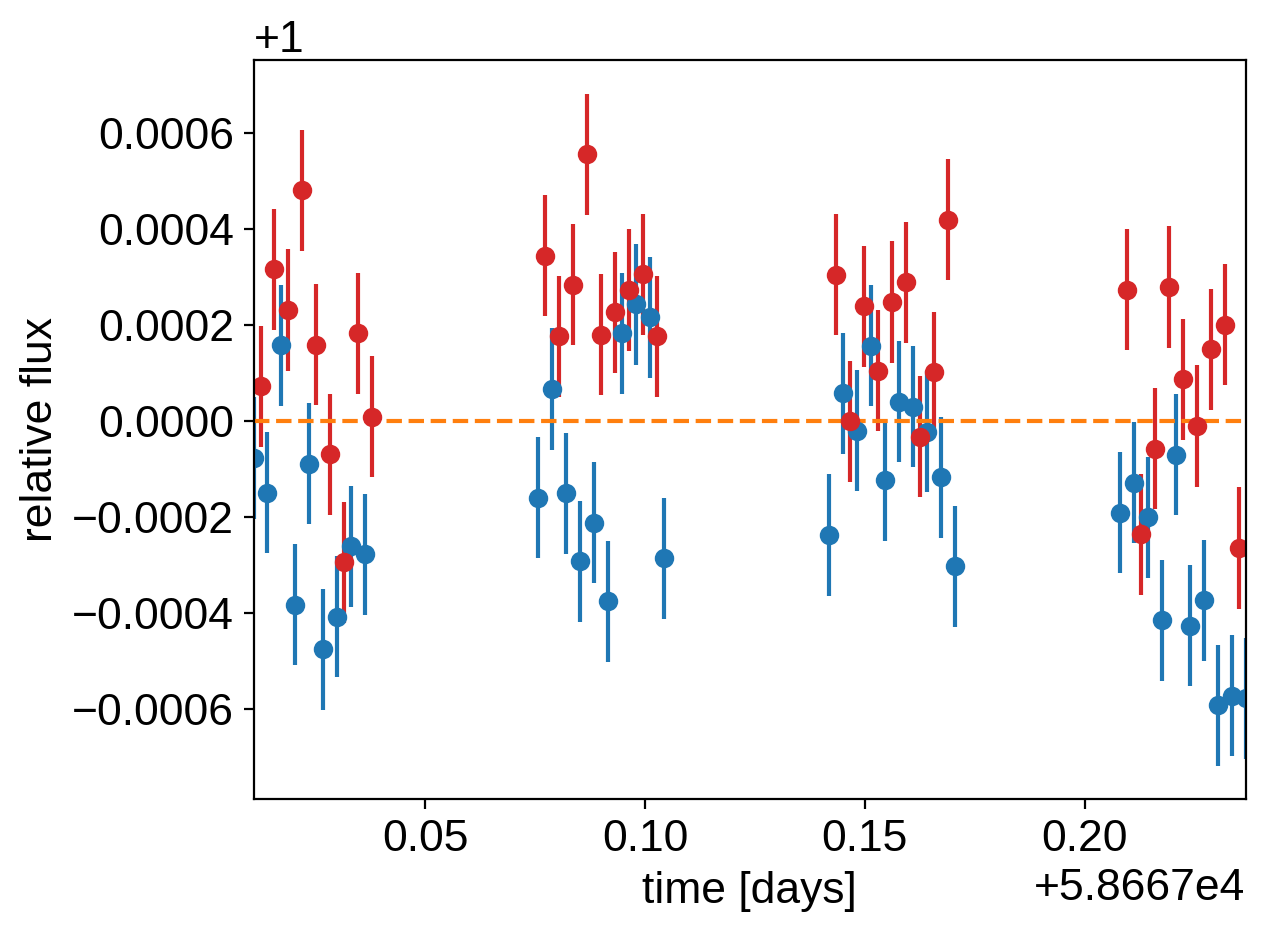

In [17]:
# Compute a limb-darkened light curve using starry
times = planet.times
u = []
flux = planet.normed_photometry_df[fine_min_snr_colname]
yerr = planet.normed_uncertainty_df[fine_min_snr_colname]

plt.errorbar(times[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', color="C0")
plt.errorbar(times[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', color="C3")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [18]:
np.random.seed(42)

# time_med = np.median(times)
med_t_diff = np.median(np.diff(times))

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [19]:
print(f'This instance has {mp.cpu_count()} CPUs')

This instance has 16 CPUs


In [22]:
wasp43 = exoMAST_API('WASP43b')
t0_wasp43 = wasp43.transit_time  # 55528.3684  # exo.mast.stsci.edu
period_wasp43 = wasp43.orbital_period
n_epochs = np.int(np.round(((np.median(times) - t0_wasp43) / period_wasp43)-0.5))
t0_guess = t0_wasp43 + (n_epochs+0.5) * period_wasp43

In [23]:
b = wasp43.impact_parameter # 0.66 # Hellier 2011
period = wasp43.orbital_period # 0.813475  # days # exo.mast.stsci.edu
u = [0]
t0 = wasp43.transit_time
edepth = np.sqrt(1000/1e6)

orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
injected_light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times).eval().flatten()

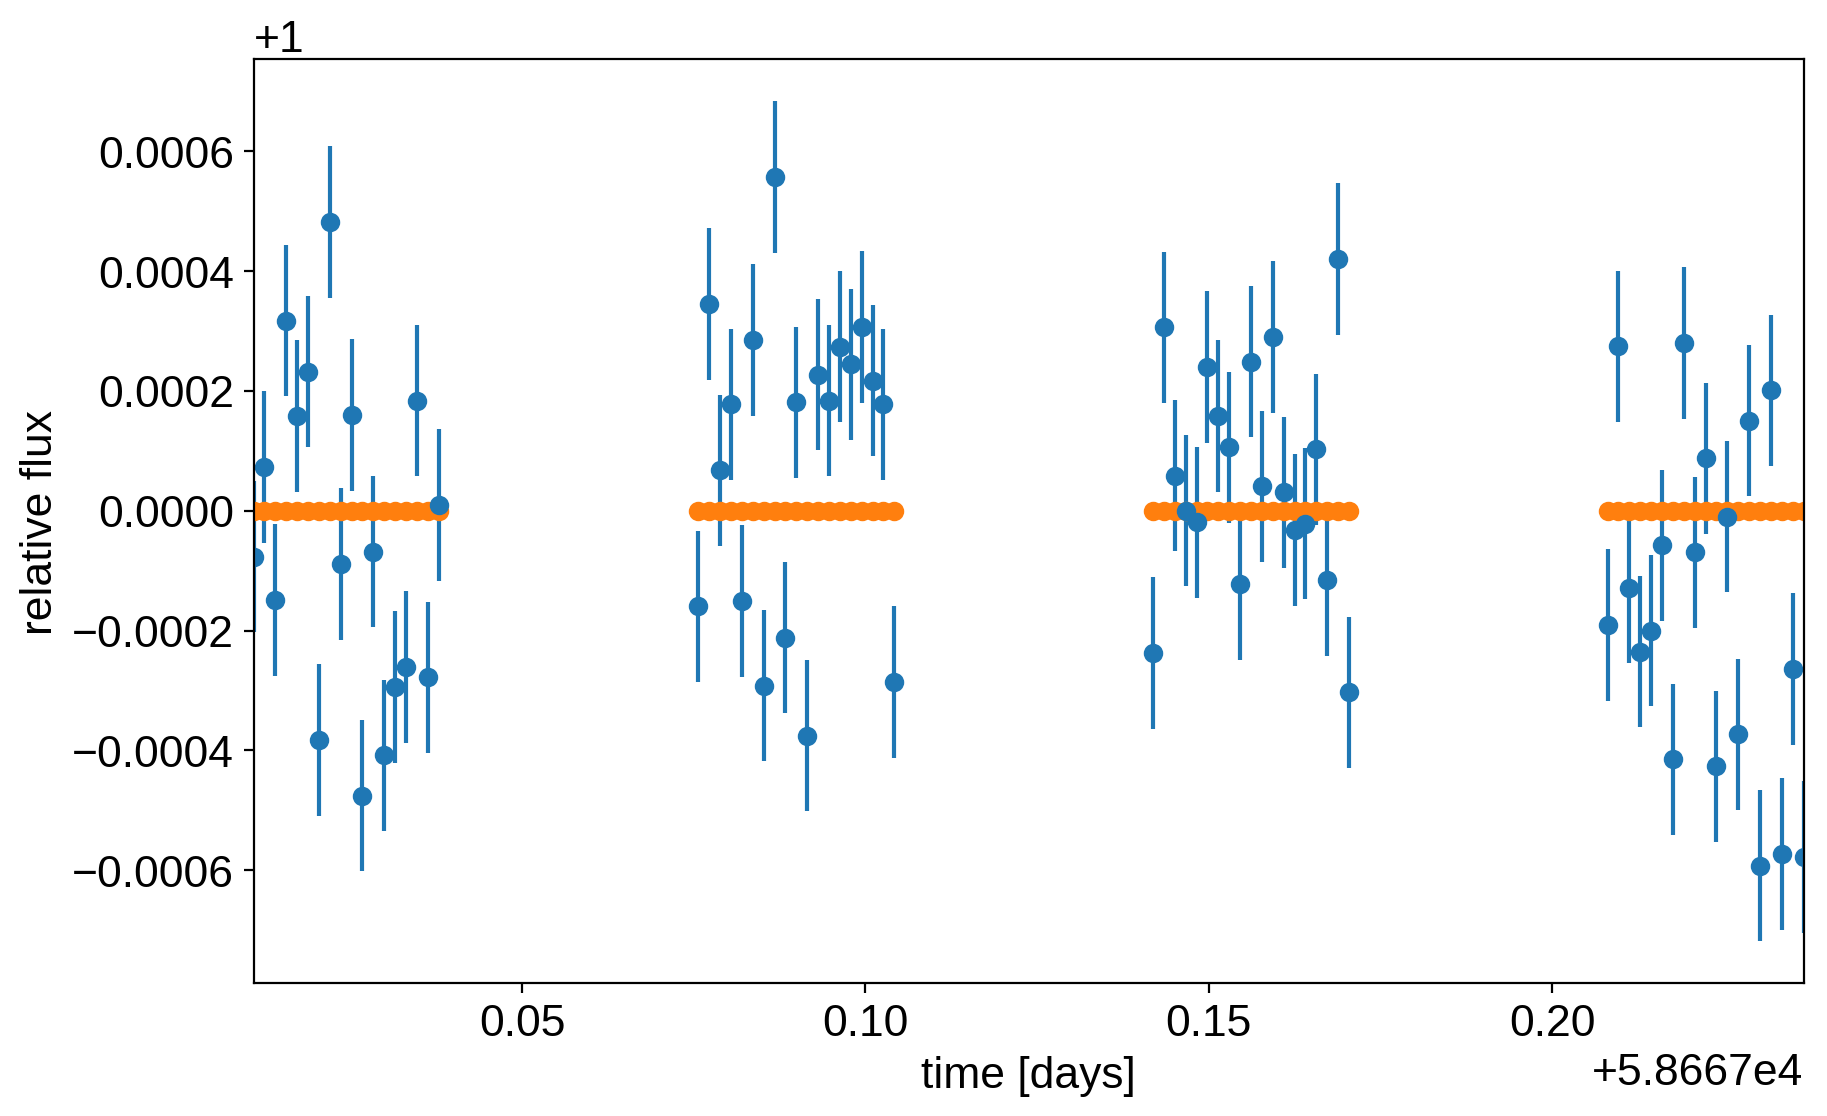

In [24]:
plt.rcParams['figure.figsize'] = (10,6)
plt.errorbar(times, flux * (injected_light_curves+1), yerr, fmt='o')
plt.plot(times, injected_light_curves+1,'o')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

# Run 400 MCMCs

In [25]:
fine_snr_flux = planet.normed_photometry_df
fine_snr_uncs = planet.normed_uncertainty_df

n_columns = len(fine_snr_flux.columns)

aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns

xcenters = planet.photometry_df['xcenter']
xcenters_mod = xcenters - np.median(xcenters)
times_mod = times - t0_guess#np.median(times)

In [44]:
n_space = 2
near_best_apertures_NxN_small = [f'aperture_sum_{aper_width_}x{aper_height_}' 
                       for aper_width_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_width)
                       for aper_height_ in (np.arange(-n_space+1,n_space)+fine_min_snr_aper_height)]

In [45]:
near_best_apertures_NxN_small,len(near_best_apertures_NxN_small)

(['aperture_sum_19x49',
  'aperture_sum_19x50',
  'aperture_sum_19x51',
  'aperture_sum_20x49',
  'aperture_sum_20x50',
  'aperture_sum_20x51',
  'aperture_sum_21x49',
  'aperture_sum_21x50',
  'aperture_sum_21x51'],
 9)

In [46]:
bad_shift = 0  # -81.26253359892871 / 60 / 24

In [47]:
plt.rcParams['figure.figsize'] = (10,6)
base_name = f'WASP43_fine_grain_photometry_208ppm_near_best_{n_space}x{n_space}'
# times-bad_shift
start0 = time()
start1 = time()
### Linear Eclipse Depths without Negative Allowed
print('Linear Eclipse depth fits - Default everything')
fine_grain_mcmcs_with_no_xcenter_lin_edepth_no_split, filename0 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=None, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=False, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Linear Eclipse depth fits - Everything with splitting fwd rev')
fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split, filename1 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=None, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=True, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Linear Eclipse depth fits - Everything with xcenter')
fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split, filename2 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=xcenters_mod, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=False, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Linear Eclipse depth fits - Everything with xcenter and splitting fwd rev')
fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split, filename3 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=xcenters_mod, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=True, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

### Linear Eclipse Depths with Negative Allowed
start1 = time()
print('Linear Eclipse depth fits - Default everything')
fine_grain_mcmcs_with_no_xcenter_lin_edepth_no_split_w_negEcl, filename8 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=None, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=True,
    use_rev_fwd_split=False, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Linear Eclipse depth fits - Everything with splitting fwd rev')
fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split_w_negEcl, filename9 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=None, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=True,
    use_rev_fwd_split=True, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Linear Eclipse depth fits - Everything with xcenter')
fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split_w_negEcl, filename10 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=xcenters_mod, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=True,
    use_rev_fwd_split=False, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Linear Eclipse depth fits - Everything with xcenter and splitting fwd rev')
fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split_w_negEcl, filename11 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=xcenters_mod, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=True,
    use_rev_fwd_split=True, use_log_edepth=False,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

### Logarithmic Eclipse Depths
start1 = time()
print('Log Eclipse depth fits - Default everything')
fine_grain_mcmcs_with_no_xcenter_log_edepth_no_split, filename4 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=None, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=False, use_log_edepth=True,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Log Eclipse depth fits - Everything with splitting fwd rev')
fine_grain_mcmcs_with_no_xcenter_log_edepth_w_split, filename5 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=None, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=True, use_log_edepth=True,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Log Eclipse depth fits - Everything with xcenter')
fine_grain_mcmcs_with_w_xcenter_log_edepth_no_split, filename6 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=xcenters_mod, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=False, use_log_edepth=True,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

start1 = time()
print('Log Eclipse depth fits - Everything with xcenter and splitting fwd rev')
fine_grain_mcmcs_with_w_xcenter_log_edepth_w_split, filename7 = run_multiple_pymc3(
    times, fine_snr_flux, fine_snr_uncs, near_best_apertures_10x10,  # [fine_min_snr_colname], # aper_sum_columns,  # 
    xcenters=xcenters_mod, tune=3000, draws=3000, target_accept=0.9,
    do_mcmc=True, save_as_you_go=True, allow_negative_edepths=False,
    use_rev_fwd_split=True, use_log_edepth=True,
    injected_light_curve=1.0, base_name=base_name)
print(f'[INFO] This MCMCs took {(time() - start1)/60:0.2f} minutes')

print(f'[INFO] All 12 MCMCs took {(time() - start0)/60:0.2f} minutes')

Linear Eclipse depth fits - Default everything


NameError: name 'run_multiple_pymc3' is not defined

In [ ]:
mcmc_fits = [fine_grain_mcmcs_with_no_xcenter_lin_edepth_no_split,
             fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split,
             fine_grain_mcmcs_with_no_xcenter_lin_edepth_no_split_w_negEcl,
             fine_grain_mcmcs_with_no_xcenter_lin_edepth_w_split_w_negEcl,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_no_split_w_negEcl,
             fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split_w_negEcl,
             fine_grain_mcmcs_with_no_xcenter_log_edepth_no_split,
             fine_grain_mcmcs_with_no_xcenter_log_edepth_w_split,
             fine_grain_mcmcs_with_w_xcenter_log_edepth_no_split,
             fine_grain_mcmcs_with_w_xcenter_log_edepth_w_split
            ]

In [ ]:
def setup_and_plot_GTC(mcmc_fit):
    trace = mcmc_fit[fine_min_snr_colname]['trace']
    map_soln = mcmc_fit[fine_min_snr_colname]['map_soln']
    
    if trace is None:
        return
    
    varnames = [key for key in map_soln.keys()
                if '__' not in key and 'light' not in key]
    
    print(pm.summary(trace, varnames=varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']])
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    if 'log_edepth' in samples.columns:
        samples['edepth'] = 10**samples['log_edepth']
    else:
        print('\n\n**NO LOG EDEPTH**')
        samples['log_edepth'] = np.log10(samples['edepth'])
    
    figureSize = (20,20)
    nSig = 3
    paramRanges = [[np.median(samples[colname]) - mad(samples[colname])] for colname in samples.columns]
    # paramRanges = {'edepth':[0,2e-3]}
    
    # print(np.mean(samples['edepth'])*1e6, 10**np.mean(samples['log_edepth'])*1e6, np.mean(10**samples['log_edepth'])*1e6)
    # print(mad(samples['edepth'])*1e6, 10**mad(samples['log_edepth'])*1e6, mad(10**samples['log_edepth'])*1e6)
    pygtc.plotGTC(samples, nContourLevels=3, figureSize='MNRAS_page');

In [ ]:
import pygtc
plt.rcParams['figure.figsize'] = 20,20
for mcmc_fit_ in mcmc_fits:
    setup_and_plot_GTC(mcmc_fit_)

In [ ]:
[key for key in fine_grain_mcmcs_with_w_xcenter_lin_edepth_w_split['aperture_sum_20x50']['map_soln'].keys()
                if '__' not in key and 'light' not in key]

In [ ]:
pm.summary(trace, varnames=varnames)

In [ ]:
import pygtc
plt.rcParams['figure.figsize'] = 10,10

trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

samples = pm.trace_to_dataframe(trace, varnames=varnames)
samples['edepth'] = 10**samples['log_edepth']

pygtc.plotGTC(samples, nContourLevels=3);

In [ ]:
from scipy.special import erf
sigmas = erf(np.arange(1,6)/np.sqrt(2))
print(np.percentile(samples['edepth'], sigmas*100)*1e6)
print(10**(np.percentile(samples['log_edepth'], sigmas*100))*1e6)

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [ ]:
aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns
aper_sum_columns

In [ ]:
trace_ = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']
dir(trace_)
trace_.report._gelman_rubin.values()
dir(trace_.report)
trace_.report._run_convergence_checks??

In [ ]:
# fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['map_soln']
edepths = []
means = []
slopes = []
slopes_xcenter = []

edepths_unc = []
means_unc = []
slopes_unc = []
slopes_xcenter_unc = []

mesh_widths = []
mesh_heights = []

for colname in tqdm(aper_sum_columns):
    aper_width_, aper_height_ = np.int32(colname.split('_')[-1].split('x'))
    mesh_widths.append(aper_width_)
    mesh_heights.append(aper_height_)

    # Load Summary from Colname
    summary_df = pm.summary(fine_grain_mcmcs_w_xcenterfit[colname]['trace'], varnames=varnames)

    # Store mean values
    edepths.append(summary_df['mean'].loc['edepth'])
    means.append(summary_df['mean'].loc['mean'])
    slopes.append(summary_df['mean'].loc['slope'])
    slopes_xcenter.append(summary_df['mean'].loc['slope_xcenter'])

    # Store uncertainties
    edepths_unc.append(summary_df['sd'].loc['edepth'])
    means_unc.append(summary_df['sd'].loc['mean'])
    slopes_unc.append(summary_df['sd'].loc['slope'])
    slopes_xcenter_unc.append(summary_df['sd'].loc['slope_xcenter'])

In [ ]:
df_columns = ["aper_width", "aper_height", "edepth", "mean", "slope", "slope_xcenter"]
means_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths, means, slopes, slopes_xcenter]), 
                        columns=df_columns)
uncs_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths_unc, means_unc, slopes_unc, slopes_xcenter_unc]), 
                        columns=df_columns)

In [ ]:
# mesh_widths_sorted = np.argsort(mesh_widths)
# mesh_heights_sorted = np.argsort(mesh_heights)
plt.plot(means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']), '.')
plt.plot(means_df['aper_height'], (means_df['edepth'] / uncs_df['edepth']),'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']),'.')

In [ ]:
mesh_widths_sorted = np.argsort(mesh_widths)
mesh_heights_sorted = np.argsort(mesh_heights)

plt.figure()
plt.plot(means_df['aper_width'], means_df['mean'],'.')
plt.plot(means_df['aper_height'], means_df['mean'],'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], means_df['mean'],'.')

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import pygtc
import corner

In [ ]:
trace = fine_grain_mcmcs_w_xcenterfit[fine_min_snr_colname]['trace']

In [ ]:
n_lightcurves_fwd = trace['light_curves_fwd'].shape[0]
light_curves_fwd = trace['light_curves_fwd'].reshape(trace['light_curves_fwd'].shape[:2])#trace['mean_fwd'][:,None]

n_lightcurves_rev = trace['light_curves_rev'].shape[0]
light_curves_rev = trace['light_curves_rev'].reshape(trace['light_curves_rev'].shape[:2])#trace['mean_rev'][:,None]

for k in np.random.choice(np.arange(n_lightcurves_fwd), size=100):
    plt.plot(t[idx_fwd], light_curves_fwd[k], '.', color='C0', alpha=0.25)

for k in np.random.choice(np.arange(n_lightcurves_rev), size=100):
    plt.plot(t[idx_rev], light_curves_rev[k], '.', color='C1', alpha=0.25)

plt.ylim(-1e-5, 1e-6);
plt.xlim(t0_guess - 0.1, t0_guess + 0.1);

In [ ]:
for colname in tqdm(aper_sum_columns):
    trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    truth = [0.0, 1.0, 1.0, 0.0]
    corner.corner(samples, truths=truth, labels=varnames);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

In [ ]:
line_fit.shape

In [ ]:
plt.figure()
# Get the posterior median orbital parameters
p = period
# t0 = np.median(trace["t0"])

# Plot the folded data
line_fit =  + trace['slope_xcenter'] + trace['slope']
line_fit = slope * (t-t0_guess) + mean + slope * (xcenters-np.median(xcenters))

plt.errorbar(times[idx_fwd] - t0, (data - line_fit + 1.0)[idx_fwd], yerr=yerr[idx_fwd], fmt=".", color='C0', label="fwd data", zorder=-1000)
plt.errorbar(times[idx_rev] - t0, (data - line_fit + 1.0)[idx_rev], yerr=yerr[idx_rev], fmt=".", color='C3', label="rev data", zorder=-1000)

# Plot the folded model
preds_fwd = trace["light_curves"][:,:,0]
# preds_rev = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred_fwd = np.median(preds_fwd, axis=0)
# pred_rev = np.median(preds_rev, axis=0)


plt.plot(times - t0, pred_fwd, color="C1", label="model", zorder=10)
# plt.plot(t[idx_rev] - t0, pred_rev, color="C2", label="model", zorder=10)
plt.axhline(1.0, ls='--', color='k')

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace['edepth']*1e6):.0f}"
txt += f" +/- {np.std(trace['edepth']*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

add_traces = False
if add_traces:
    n_traces = 1000
    
    idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    for pred_ in preds_fwd[idx_rand]:
        plt.plot(times - t0, pred_, color="grey", alpha=0.5, zorder=0)

    # idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    # for pred_ in preds_rev[idx_rand]:
    #     plt.plot(t[idx_rev] - t0, pred_, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((times - t0).min(), (times - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")